# Preprocesamiento y EDA

Antes de seleccionar los modelos, se debe realizar un análisis de los datos con los que estamos trabajando. Así, se podrá elegir el mejor modelo para implementar.

El dataset con que estamos trabajando contiene señales EEG de sujetos de dos grupos, alcohólicos o controles. Se presentaron uno o dos estímulos (S1 o S1 y S2) en condiciones coincidentes (S1 = S2) o no coincidentes (S1 ̸= S2), con el objetivo de registrar la actividad cerebral mediante EEG durante el procesamiento visual y la toma de decisiones.

Sin embargo, la data se encuentra en un archivo .h5, que está diseñado para almacenar grandes cantidades de datos complejos. Por esta razón, no se puede trabajar de forma directa con el archivo.

Es por ello que se ha realizado un pipeline que extrae las caracteríticas más relevantes de nuestra base de datos (estamos trabajando con series de tiempo) y almacena dichos resultados en archivos .csv, que son más fáciles de manejar.

In [1]:
# Se importan las librerías necesarias para el procesamiento de datos y la extracción de características (tsfresh)
import os
import h5py
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Usaremos la librería h5py para abrir y leer archivos .h5:

In [38]:
train_file = "../train.h5"
test_file = "../test.h5"

with h5py.File(train_file, "r") as f:
    X_train = f["x"][:]   # señales EEG
    y_train = f["y"][:]   # etiquetas

with h5py.File(test_file, "r") as f:
    X_test = f["x"][:]    # señales EEG

# Exploración rápida
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_train[0,0,:5])  # primeras 5 muestras de EEG del primer sujeto
print(y_train[:5])       # primeras 5 etiquetas

(204, 1, 18530) float64
(204,) int64
[-0.00585938 -0.01141357 -0.01077271 -0.01055908 -0.0088501 ]
[0 1 0 0 0]


Se puede observar que la base de datos tiene registros de 204 personas. X_train contiene un atributo "y" que corresponde a las etiquetas, es decir, a los outputs (0 para control y 1 para alcoholicos). Este atributo fue guardado en y_train. Para cada persona, hay un total de 18530 registros de puntos que corresponden a su electroencefalograma. X_test contiene a otras 204 personas con sus respectivas muestras de EEG.

In [39]:
# Visualización de y_train 
y_train 
# Vemos que es un atributo binario (0 y 1)

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1])

Se hizo un análisis de la distribución de los valores de y_train

In [40]:
# Análisis de distribución de clases
y, counts = np.unique(y_train, return_counts=True)
for label, count in zip(y, counts):
    print(f"Clase {label}: {count} muestras, proporción: {count/len(y_train):.2%}")

Clase 0: 149 muestras, proporción: 73.04%
Clase 1: 55 muestras, proporción: 26.96%


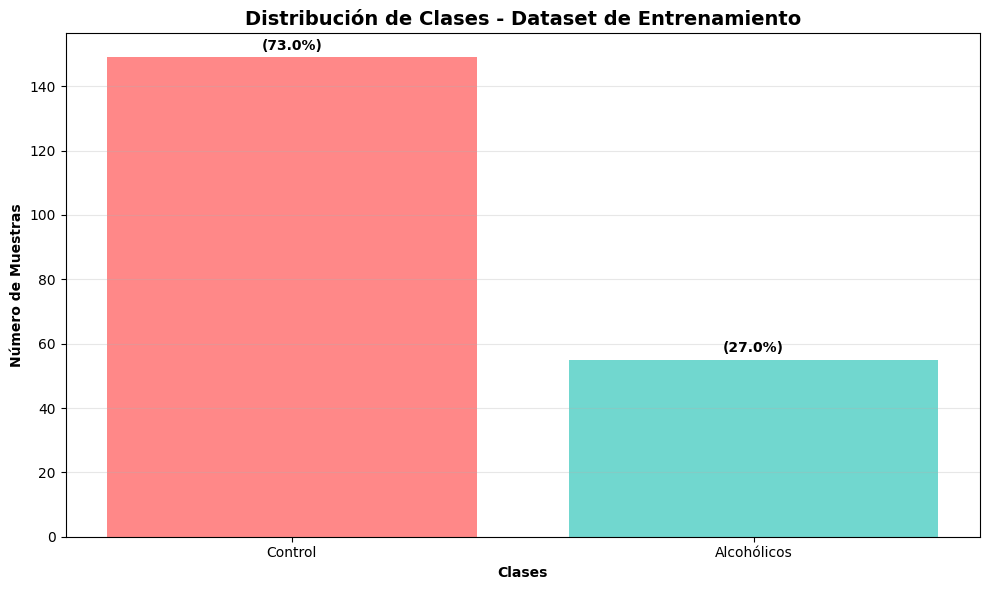

In [41]:
labels = ['Control', 'Alcohólicos']  # Clase 0: Control, Clase 1: Alcohólicos
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
# Añadir valores en las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             f'({count/len(y_train):.1%})', 
             ha='center', va='bottom', fontweight='bold')

plt.title('Distribución de Clases - Dataset de Entrenamiento', fontsize=14, fontweight='bold')
plt.ylabel('Número de Muestras', fontweight='bold')
plt.xlabel('Clases', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

En el gráfico se puede observar como están distribuidas las clases en la base de datos. Lo primero que se observa inmediatamente es que existe un desbalance entre las clases, ya que la clase "control" equivale a casi 3/4 de los datos del dataset. Esto podría implicar que los modelos a implementar tengan un alto accuracy general, pero un rendimiento pobre en la clase minoritaria. Además, puede existir la posibilidad de que haya overfitting en la clase mayoritaria. 

Una posible solución para esto es utilizar Synthetic Minority Over-Sample technique o mejor conocido como SMOTE, que consiste en duplicar ejemplos de la clase minoritaria (como hace el oversampling tradicional). SMOTE crea ejemplos sintéticos nuevos combinando instancias existentes de la clase minoritaria. Por ende, sería conveniente utilizarlo para generar una distribución equitativa de los datos.

In [42]:
# Convertir a DataFrame ancho
x_h5_train_df = pd.DataFrame(X_train[:,0,:])
y_h5_train_df = pd.Series(y_train)

def parsear_times_series(dataset):
    parsed_data = []
    for id, series in enumerate(dataset):
        time_series_df = pd.DataFrame({
            'id': id,
            'time': np.arange(len(series)),
            'value': series
        })
        parsed_data.append(time_series_df)
    return pd.concat(parsed_data)

# Parsear train y test (primer canal [:,0,:])
long_train_df = parsear_times_series(X_train[:,0,:])
long_test_df = parsear_times_series(X_test[:,0,:])

y_train_series = pd.Series(y_train)

In [43]:
long_train_df.head()


,id,time,value
0,0,0,-0.005859
1,0,1,-0.011414
2,0,2,-0.010773
3,0,3,-0.010559
4,0,4,-0.008850


In [44]:
y_train_series

0      0
1      1
2      0
3      0
4      0
      ..
199    0
200    0
201    0
202    0
203    1
Length: 204, dtype: int64

In [45]:
def procesar_en_bloques(long_df, y_labels=None, bloque_size=5, dataset_name="train"):
    os.makedirs("features_chunks", exist_ok=True)
    n_ids = long_df['id'].nunique()
    chunks_files = []

    # 🔹 Cambio a EfficientFCParameters
    fc_parameters = EfficientFCParameters()  # Más características balanceadas

    for start in range(0, n_ids, bloque_size):
        end = min(start + bloque_size, n_ids)
        bloque_ids = list(range(start, end))
        bloque_df = long_df[long_df['id'].isin(bloque_ids)]

        # Extraer features
        features_bloque = extract_features(
            bloque_df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=fc_parameters
        )
        impute(features_bloque)
        # Guardar CSV temporal
        file_path = f"features_chunks/{dataset_name}_features_{start}_{end}.csv"
        features_bloque.to_csv(file_path)
        chunks_files.append(file_path)
        print(f"Bloque {start}-{end} procesado y guardado en {file_path}")

    # Combinar todos los CSVs
    features_final = pd.concat([pd.read_csv(f, index_col=0) for f in chunks_files])

    # Selección de features si hay etiquetas
    if y_labels is not None:
        features_final = select_features(features_final, y_labels)

    # 🔹 Guardar el archivo combinado
    final_file = f"features_chunks/{dataset_name}_features_final.csv"
    features_final.to_csv(final_file)
    print(f"Features combinadas guardadas en {final_file}")

    return features_final

In [ ]:
X_train_features = procesar_en_bloques(long_train_df, y_labels=y_train_series, bloque_size=5, dataset_name="train")

In [ ]:
X_test_features = procesar_en_bloques(long_test_df, y_labels=None, bloque_size=5, dataset_name="test")

In [ ]:
X_train_features.shape 


In [42]:
X_test_features.shape

(205, 777)

In [43]:
# Alinear columnas (usar solo columnas de train en test)
X_test_features = X_test_features[X_train_features.columns]

In [44]:
X_test_features.shape

(205, 208)

In [47]:
from pandas import read_csv
X_train_features = read_csv("../train_features_final.csv", index_col=0)
X_test_features = read_csv("../test_features_final.csv", index_col=0)

In [48]:
X_train_features

,value__permutation_entropy__dimension_3__tau_1,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2",value__number_peaks__n_1,value__number_cwt_peaks__n_1,value__permutation_entropy__dimension_4__tau_1,value__ar_coefficient__coeff_1__k_10,"value__fft_coefficient__attr_""abs""__coeff_47","value__fft_coefficient__attr_""abs""__coeff_41",value__partial_autocorrelation__lag_3,value__permutation_entropy__dimension_5__tau_1,...,"value__fft_coefficient__attr_""abs""__coeff_86","value__fft_coefficient__attr_""abs""__coeff_1","value__fft_coefficient__attr_""abs""__coeff_33",value__time_reversal_asymmetry_statistic__lag_1,"value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0","value__fft_coefficient__attr_""abs""__coeff_89","value__fft_coefficient__attr_""abs""__coeff_91","value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0","value__fft_coefficient__attr_""abs""__coeff_14","value__fft_coefficient__attr_""abs""__coeff_93"
0,1.222197,0.000040,1351.0,873.0,1.779523,1.099913,0.397931,0.683866,-0.364176,2.375477,...,5.934038,0.245357,0.182604,2.253826e-07,2.407455e-07,11.645361,1.970055,0.000025,0.235836,20.580992
1,1.148054,0.000006,1098.0,666.0,1.645622,2.443051,4.304379,2.595552,0.503543,2.196140,...,7.017461,0.784430,0.785116,-5.500504e-07,-3.590889e-05,4.065308,19.633347,-0.000084,0.832623,27.849239
2,1.649418,0.000006,3688.0,1041.0,2.545695,1.211280,0.771397,0.539487,-0.654519,3.470808,...,5.505441,0.014523,0.353094,-4.624650e-08,9.456874e-07,1.720942,4.444360,0.000003,0.099937,5.797883
3,1.663552,0.000002,3824.0,1248.0,2.610122,1.117250,0.945263,0.533933,-0.500066,3.569896,...,11.983489,0.510892,0.483033,-3.212951e-09,-6.622333e-06,9.073884,4.981807,-0.000022,0.516657,5.203681
4,1.479723,-0.000054,2564.0,848.0,2.184056,0.861699,3.127330,1.090146,-0.574134,2.926665,...,7.037917,0.061637,1.165157,-3.382571e-07,-4.553208e-05,5.722260,10.353576,-0.000057,0.214970,8.361567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.752684,0.000002,4903.0,1280.0,2.775545,1.059679,0.150297,0.464666,-0.565589,3.782724,...,2.865507,0.154394,0.431128,-2.936306e-08,-1.969392e-05,3.511455,1.815426,-0.000028,0.174712,3.038189
200,1.721757,0.000005,4473.0,915.0,2.729553,1.359885,1.368622,1.339887,-0.566730,3.774043,...,14.982187,0.280131,0.242895,-9.332547e-08,-4.002630e-05,18.296807,11.901449,0.000026,0.244938,25.547972
201,1.210007,-0.000083,1314.0,762.0,1.724411,1.744408,1.403609,0.170579,-0.157084,2.278402,...,20.477561,0.698864,0.922586,-9.131813e-09,-1.778715e-05,6.643075,47.081911,0.000017,0.705191,38.727129
202,1.604492,-0.000009,3258.0,934.0,2.468804,0.951695,0.459324,1.296269,-0.339121,3.394110,...,1.571993,0.090799,0.404411,-2.177782e-09,9.108441e-07,2.024735,2.667694,-0.000005,0.095374,0.762869


In [50]:
# Aplicar ANOVA y obtener resultados detallados
f_scores, p_values = f_classif(X_train_features, y_train_series)

# Crear DataFrame con resultados
anova_results = pd.DataFrame({
    'Feature': X_train_features.columns,
    'F_Score': f_scores,
    'P_Value': p_values,
    'neg_log_pvalue': -np.log10(p_values)  # Para visualización
})

# Ordenar por F-score
anova_results_sorted = anova_results.sort_values('F_Score', ascending=False)

# Seleccionar top 40
top_20 = anova_results_sorted.head(40)

print("="*60)
print("TOP 20 CARACTERÍSTICAS POR ANOVA F-TEST")
print("="*60)
print(f"{'Feature':<30} {'F-Score':<10} {'P-Value':<10} {'-log10(P)':<10}")
print("-"*60)

for idx, row in top_20.iterrows():
    print(f"{row['Feature']:<30} {row['F_Score']:<10.2f} {row['P_Value']:<10.4f} {row['neg_log_pvalue']:<10.2f}")



TOP 20 CARACTERÍSTICAS POR ANOVA F-TEST
Feature                        F-Score    P-Value    -log10(P) 
------------------------------------------------------------
value__permutation_entropy__dimension_3__tau_1 37.62      0.0000     8.35      
value__permutation_entropy__dimension_4__tau_1 32.56      0.0000     7.39      
value__partial_autocorrelation__lag_3 32.14      0.0000     7.31      
value__ar_coefficient__coeff_2__k_10 30.09      0.0000     6.91      
value__permutation_entropy__dimension_5__tau_1 30.05      0.0000     6.90      
value__permutation_entropy__dimension_6__tau_1 28.51      0.0000     6.60      
value__number_cwt_peaks__n_1   27.44      0.0000     6.39      
value__number_peaks__n_1       27.05      0.0000     6.32      
value__permutation_entropy__dimension_7__tau_1 26.86      0.0000     6.28      
value__ar_coefficient__coeff_1__k_10 24.36      0.0000     5.78      
value__fft_aggregated__aggtype_"kurtosis" 19.83      0.0000     4.85      
value__maximum       

In [51]:

X_train_top20 = X_train_features[top_20['Feature']]
X_test_top20 = X_test_features[top_20['Feature']]

In [52]:
# A X_train_top20 agregale el target como columna 
X_train_top20 = X_train_top20.copy()  # Evitar SettingWithCopyWarning
X_train_top20['target'] = y_train_series

In [55]:
# Guarda los datasets en CSV
X_train_top20.to_csv("X_train_top20_features.csv", index=False)
X_test_top20.to_csv("X_test_top20_features.csv", index=False)

In [53]:
X_train_top20

,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__partial_autocorrelation__lag_3,value__ar_coefficient__coeff_2__k_10,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__number_cwt_peaks__n_1,value__number_peaks__n_1,value__permutation_entropy__dimension_7__tau_1,value__ar_coefficient__coeff_1__k_10,...,"value__fft_coefficient__attr_""abs""__coeff_80","value__fft_coefficient__attr_""abs""__coeff_10","value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.4","value__fft_coefficient__attr_""abs""__coeff_45","value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","value__fft_coefficient__attr_""abs""__coeff_46","value__fft_coefficient__attr_""abs""__coeff_69","value__fft_coefficient__attr_""abs""__coeff_41","value__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.4",target
0,1.222197,1.779523,-0.364176,0.039579,2.375477,3.002084,873.0,1351.0,3.596227,1.099913,...,4.613179,0.237705,0.000032,1.141066,-5.761742e-06,0.605072,1.002871,0.683866,-0.000027,0
1,1.148054,1.645622,0.503543,-2.548149,2.196140,2.777400,666.0,1098.0,3.365738,2.443051,...,16.233237,0.815082,0.000030,3.128478,2.234640e-06,2.445884,15.308225,2.595552,-0.000002,1
2,1.649418,2.545695,-0.654519,0.595491,3.470808,4.431796,1041.0,3688.0,5.335461,1.211280,...,7.032477,0.061799,0.000027,1.678751,-1.932599e-07,1.324123,2.818977,0.539487,-0.000009,0
3,1.663552,2.610122,-0.500066,0.336535,3.569896,4.564650,1248.0,3824.0,5.506580,1.117250,...,5.353137,0.512600,-0.000017,1.163504,-1.005371e-05,1.056577,0.855749,0.533933,-0.000018,0
4,1.479723,2.184056,-0.574134,0.597538,2.926665,3.690862,848.0,2564.0,4.417537,0.861699,...,8.730875,0.162363,-0.000053,0.589796,-4.356861e-05,2.168520,1.980715,1.090146,-0.000018,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.752684,2.775545,-0.565589,0.480745,3.782724,4.820104,1280.0,4903.0,5.814302,1.059679,...,6.343762,0.159482,-0.000014,0.930011,-1.784759e-05,0.419722,6.916694,0.464666,-0.000016,0
200,1.721757,2.729553,-0.566730,0.356997,3.774043,4.848910,915.0,4473.0,5.895735,1.359885,...,7.228032,0.280916,0.000012,0.538995,-1.439060e-06,0.438687,6.325546,1.339887,-0.000002,0
201,1.210007,1.724411,-0.157084,-0.622847,2.278402,2.854192,762.0,1314.0,3.407342,1.744408,...,3.813981,0.705896,-0.000039,1.770959,-4.760496e-05,0.634143,3.403509,0.170579,-0.000035,0
202,1.604492,2.468804,-0.339121,0.339161,3.394110,4.373966,934.0,3258.0,5.297560,0.951695,...,0.918280,0.088181,-0.000010,0.355331,-5.484873e-06,0.029911,0.888856,1.296269,-0.000007,0


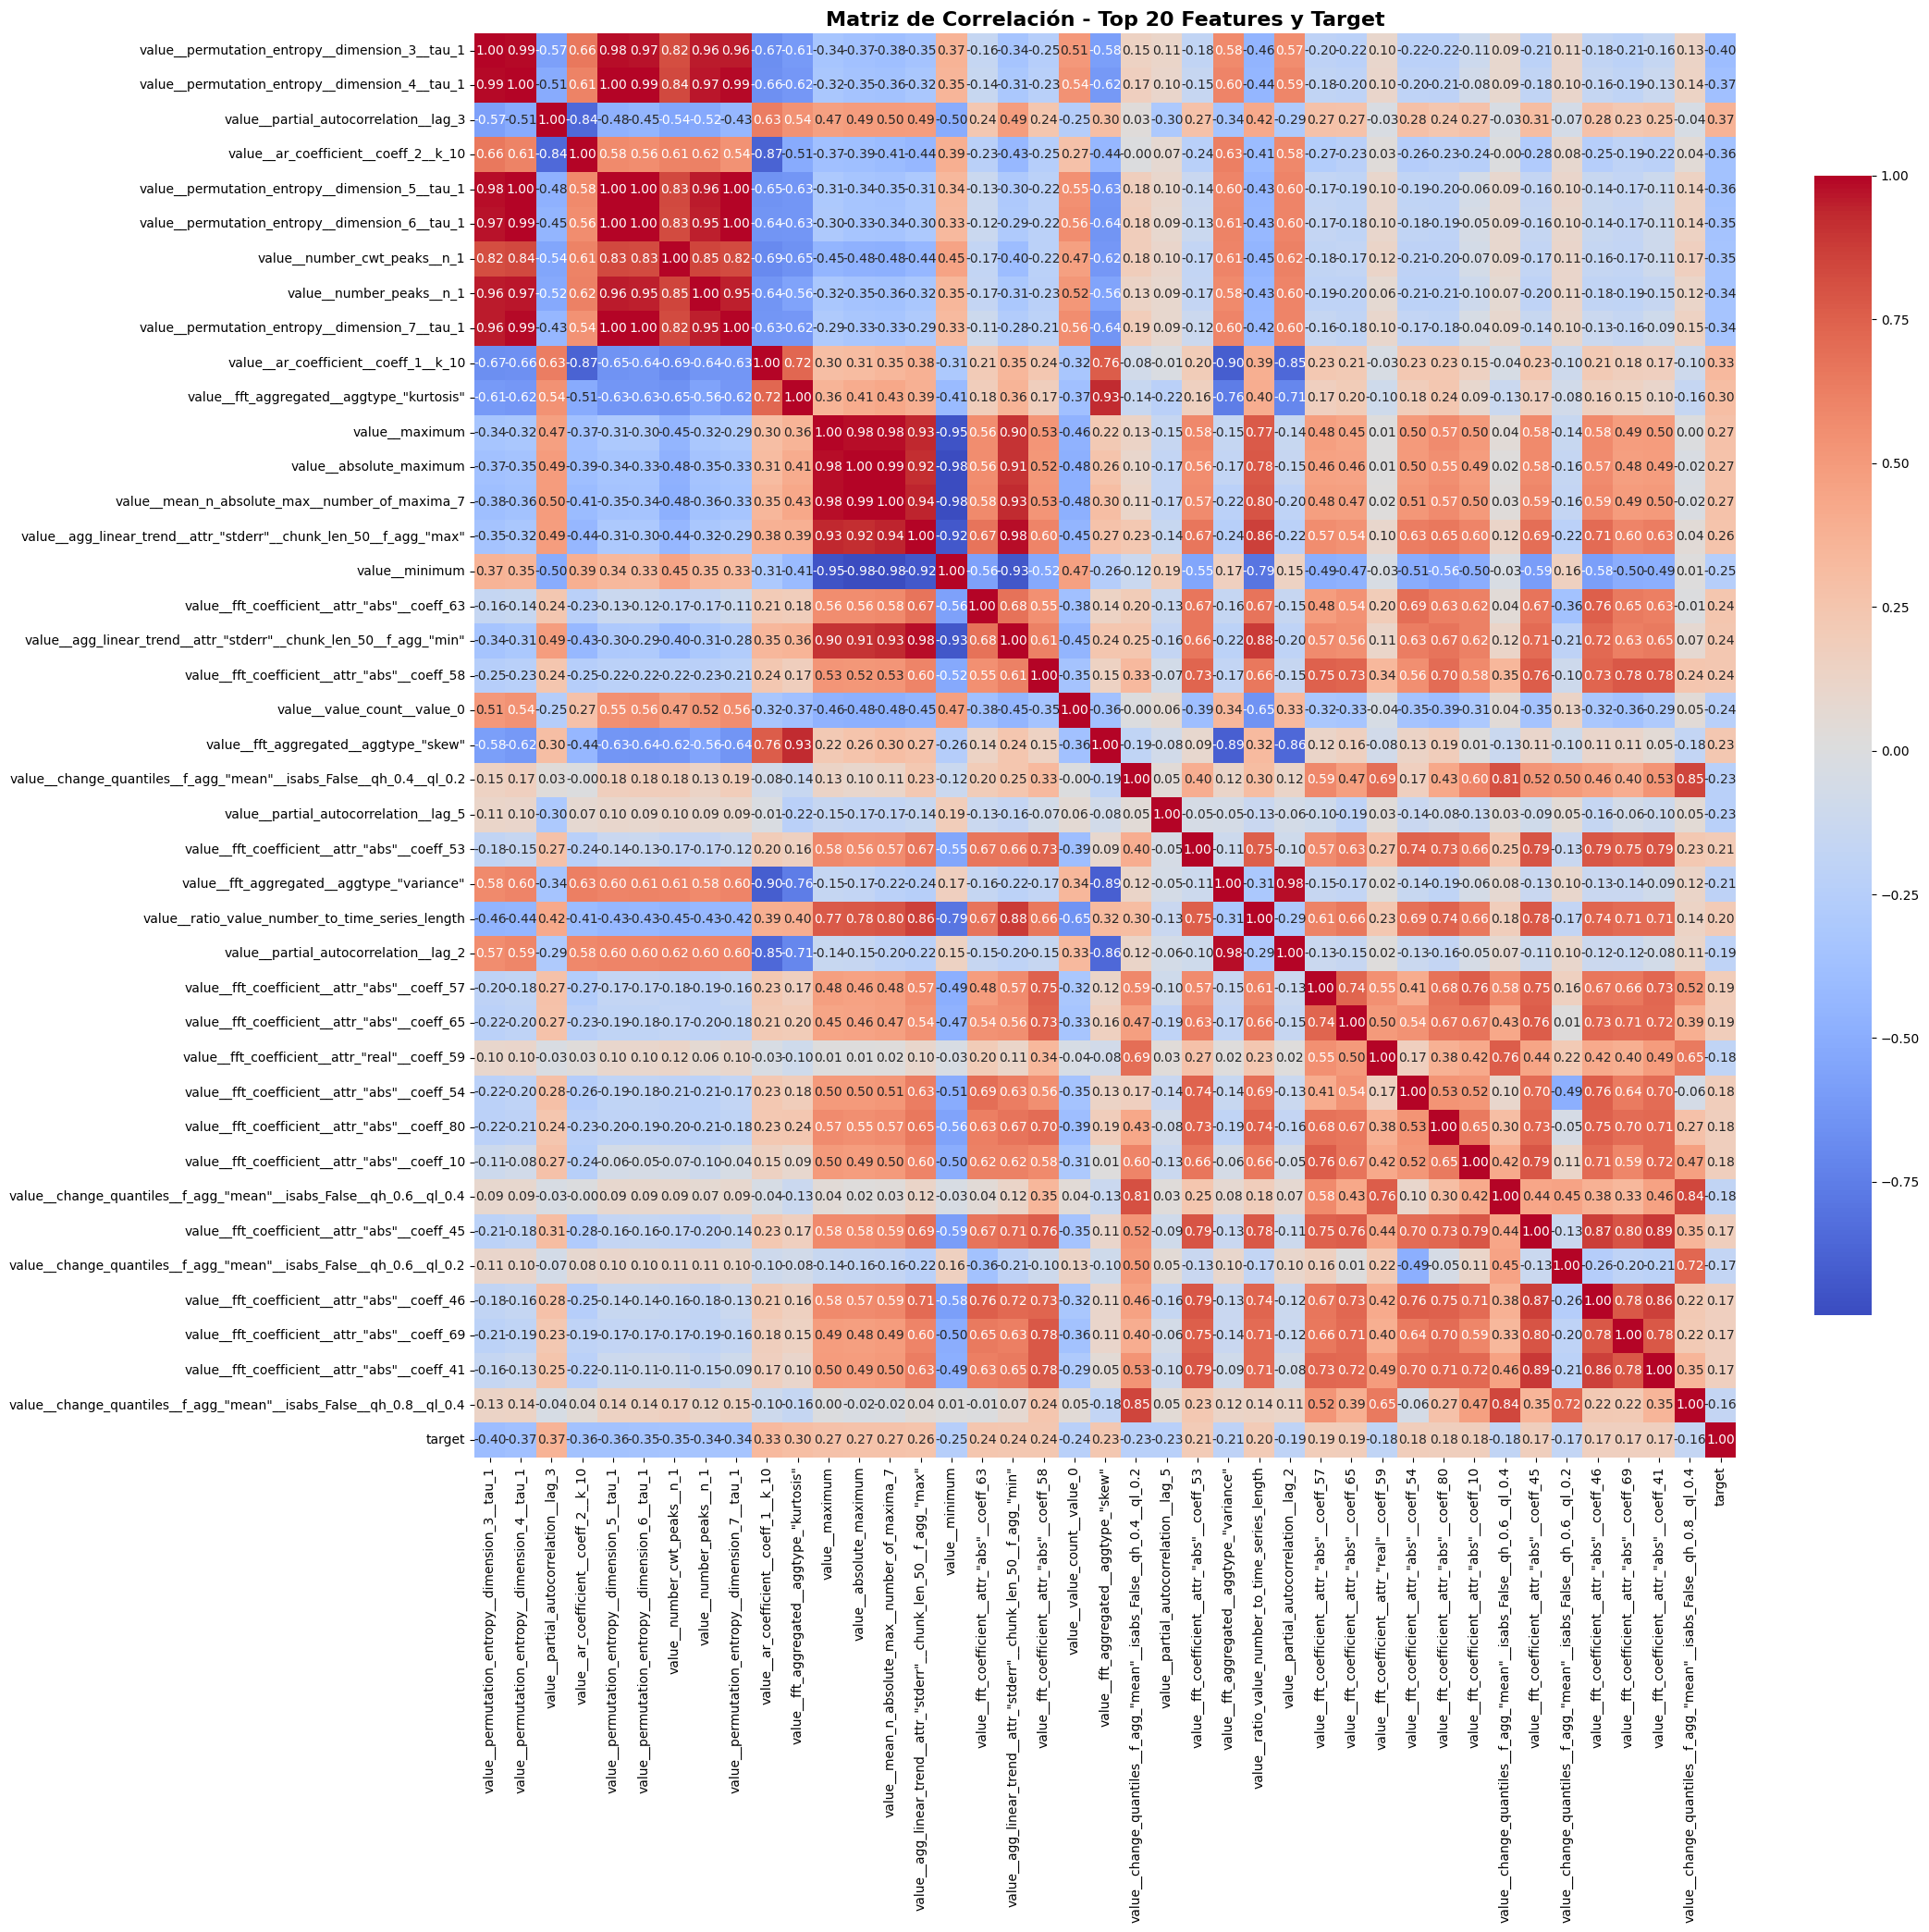

In [59]:
# Creame una matriz de correlación de las top 20 features y la target con seaborn
corr_matrix = X_train_top20.corr()
plt.figure(figsize=(22, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Top 20 Features y Target', fontsize=16, fontweight='bold')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

# Separar características y target
B = X_train_top20['target']
A = X_train_top20.drop('target', axis=1)
# Aplicar SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)  # sampling_strategy=1.0 significa 50%-50%
A_balanced, B_balanced = smote.fit_resample(A, B)

# Crear nuevo DataFrame balanceado
df_balanced = pd.DataFrame(A_balanced, columns=A.columns)
df_balanced['target'] = B_balanced

# Verificar la nueva distribución
print("Distribución después de SMOTE:")
print(f"Clase 0: {sum(B_balanced == 0)} muestras, proporción: {sum(B_balanced == 0)/len(B_balanced)*100:.2f}%")
print(f"Clase 1: {sum(B_balanced == 1)} muestras, proporción: {sum(B_balanced == 1)/len(B_balanced)*100:.2f}%")

Distribución después de SMOTE:
Clase 0: 149 muestras, proporción: 50.00%
Clase 1: 149 muestras, proporción: 50.00%


In [34]:
# Guarda el dataset balanceado en CSV
df_balanced.to_csv("X_train_top20_features_balanced.csv", index=False)